In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
importlib.reload(kgs)
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
from IPython.display import HTML, display, clear_output
from scipy import stats
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
local


In [2]:
# @dataclass
# class MegaDynamics(kgs.BaseClass):
#     # Configuration
#     n_trees = 40
#     n_ensembles = 1000
#     n_rounds = 5
#     seed = 42
#     plot_interval = None

#     # Hyperparameters
#     size_setup = 0.5 # will be mulitiplied by sqrt(n_trees)
#     duration_init = 10.
#     duration_compact = 200.
#     duration_final = 10. # careful - lowering this can seem to make things better, but actually can mean overlapping solutions
#     dt = 0.02
#     friction_min = 0.1
#     friction_max = 10.
#     friction_periods = 10
#     scaling_area_start = 0.3
#     scaling_area_end = 0.001
#     scaling_boundary = 5.
#     scaling_overlap = 1. # recommend to keep this fixed
#     scaling_overall_factor = 1.
#     use_boundary_distance = True

#     # Results
#     sizes = None # n_ensemble rows, n_round columns
#     best_size = np.inf
#     best_xyt = None
#     time = None

#     def run_simulation(self):
#         # Initial configuration
#         size_setup_scaled = self.size_setup * np.sqrt(self.n_trees)
#         xyt = np.random.default_rng(seed=self.seed).uniform(-0.5, 0.5, size=(self.n_ensembles, self.n_trees, 3))
#         xyt = xyt * [[[size_setup_scaled, size_setup_scaled, np.pi]]]
#         xyt = np.array(xyt, dtype=np.float32)
#         h = np.array([[2*size_setup_scaled]*self.n_ensembles], dtype=np.float32).T
#         cost = pack_cost.CostCompound(costs=[pack_cost.AreaCost(scaling=0.),
#                                              pack_cost.BoundaryDistanceCost(scaling=self.scaling_boundary), 
#                                              pack_cost.CollisionCostOverlappingArea(self.scaling_overlap)])
#         if not self.use_boundary_distance:
#             cost.costs[1] = pack_cost.BoundaryCost(scaling=self.scaling_boundary)


#         plt.ioff()
#         if self.plot_interval is not None:
#             plt.ion()
#             fig, ax = plt.subplots(figsize=(8, 8))
#             tree_list = kgs.TreeList()
#             #print(xyt[0].shape)
#             #tree_list.xyt = xyt[0]
#             #pack_vis.visualize_tree_list(tree_list, ax=ax, h=size_setup_scaled)
#             #display(fig)
#             #clear_output(wait=True)

#         xyt = cp.array(xyt)
#         h = cp.array(h)

#         t_total = np.float32(0.)
#         dt = np.float32(self.dt)
#         phase = 'init'
#         t_this_phase = np.float32(0.)
#         t_last_plot = np.float32(0.)
#         rounds_done = 0
#         self.sizes = np.zeros((self.n_ensembles, self.n_rounds), dtype=np.float32)
#         time_start = time.time()
#         velocity_xyt = cp.zeros_like(xyt)
#         velocity_h = cp.zeros_like(h)
#         while True:
#             if phase == 'compact':
#                 frac = t_this_phase / self.duration_compact
#                 start = self.scaling_area_start
#                 end = self.scaling_area_end
#                 area_scaling = start * (end / start) ** frac
#                 cost.costs[0].scaling = area_scaling
#                 friction = self.friction_max + (self.friction_min - self.friction_max) * (1+np.cos(frac*2*np.pi*self.friction_periods))/2
#             else:
#                 cost.costs[0].scaling = 0.
#                 friction = 1/dt
#             total_cost, total_grad, bound_grad = cost.compute_cost(xyt, h)
#             total_grad *= self.scaling_overall_factor
#             bound_grad *= self.scaling_overall_factor
#             velocity_xyt += -dt*friction*velocity_xyt - dt*total_grad
#             velocity_h += 0*velocity_h - dt*bound_grad
#             xyt += dt * velocity_xyt
#             h += dt * velocity_h
#             t_total += dt
#             t_this_phase += dt
#             if self.plot_interval is not None and t_total - t_last_plot >= self.plot_interval*0.999:
#                 t_last_plot = t_total                
#                 ax.clear()
#                 ax.set_aspect('equal', adjustable='box')
#                 tree_list.xyt = cp.asnumpy(xyt[0])
#                 pack_vis.visualize_tree_list(tree_list, ax=ax, h=cp.asnumpy(h[0,0]))
#                 ax.set_title(f'Time: {t_total:.2f}, Round:{rounds_done+1}, Phase: {phase}, Area scaling: {cost.costs[0].scaling:.4f}, Cost: {total_cost[0]:.4f}, friction: {friction}')
#                 display(fig)
#                 clear_output(wait=True)       

#             if phase == 'init' and t_this_phase >= self.duration_init:
#                 phase = 'compact'
#                 t_this_phase = 0.    
#             elif phase == 'compact' and t_this_phase >= self.duration_compact:
#                 phase = 'final'
#                 t_this_phase = 0.
#             elif phase == 'final' and t_this_phase >= self.duration_final:
#                 # Report out
#                 overlaps = pack_cost.CollisionCostOverlappingArea().compute_cost(xyt, h)[0]
#                 # Compute edge of smallest axis-aligned square containing all tree polygons for each ensemble
#                 for ei in range(self.n_ensembles):
#                     try:
#                         tree_list_local = kgs.TreeList()
#                         tree_list_local.xyt = cp.asnumpy(xyt[ei])
#                         polygons = tree_list_local.get_trees()
#                         # collect all vertex coordinates
#                         xs = []
#                         ys = []
#                         for poly in polygons:
#                             for vx, vy in poly.exterior.coords[:-1]:
#                                 xs.append(vx)
#                                 ys.append(vy)
#                             # include interior rings if present
#                             for interior in poly.interiors:
#                                 for vx, vy in interior.coords[:-1]:
#                                     xs.append(vx)
#                                     ys.append(vy)
#                         min_x = min(xs) if xs else 0.0
#                         max_x = max(xs) if xs else 0.0
#                         min_y = min(ys) if ys else 0.0
#                         max_y = max(ys) if ys else 0.0
#                         edge = float(max(max_x - min_x, max_y - min_y))
#                         self.sizes[ei, rounds_done] = edge
#                     except:
#                         self.sizes[ei,rounds_done] = np.nan                    
#                     if overlaps[ei] > 0.0001*np.sqrt(self.n_trees):
#                         self.sizes[ei, rounds_done] = np.nan
#                     if self.sizes[ei, rounds_done] < self.best_size:
#                         self.best_size = self.sizes[ei, rounds_done]
#                         self.best_xyt = cp.asnumpy(xyt[ei]) 

#                 rounds_done += 1
#                 if rounds_done >= self.n_rounds:
#                     self.time = time.time()-time_start
#                     break
                
#                 phase = 'compact'
#                 t_this_phase = 0.   

#         # If a temporary plotting figure was created, close it to release resources
#         #if self.plot_interval is not None:
#         #    plt.close(fig)
            
                                                       


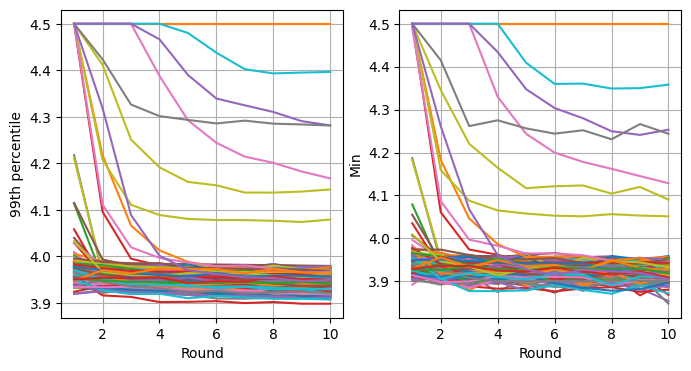

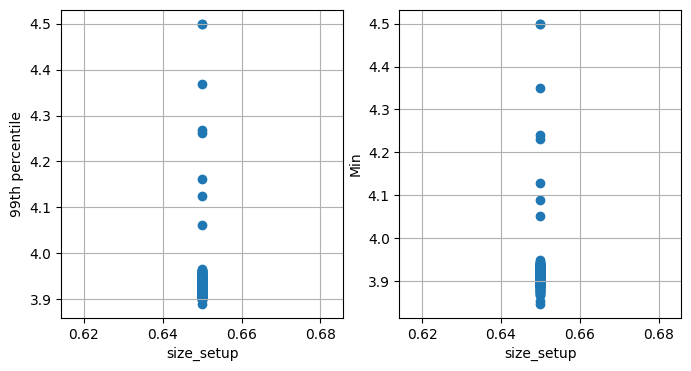

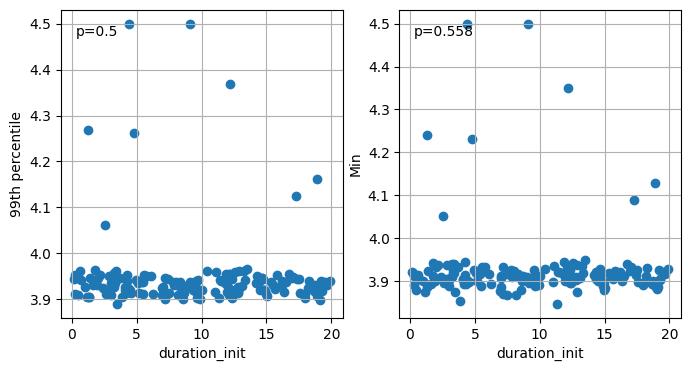

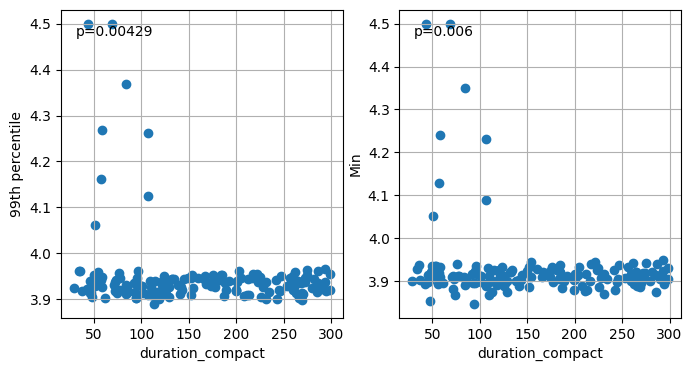

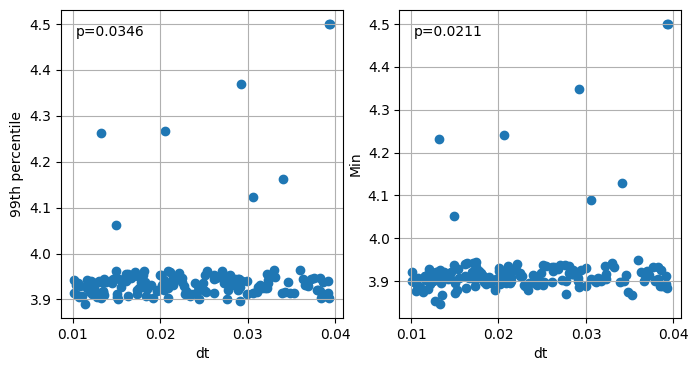

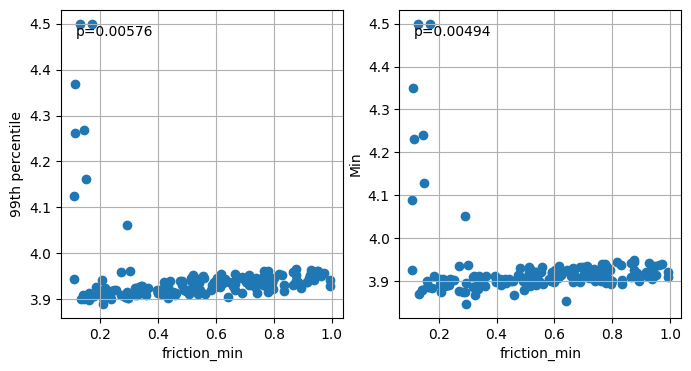

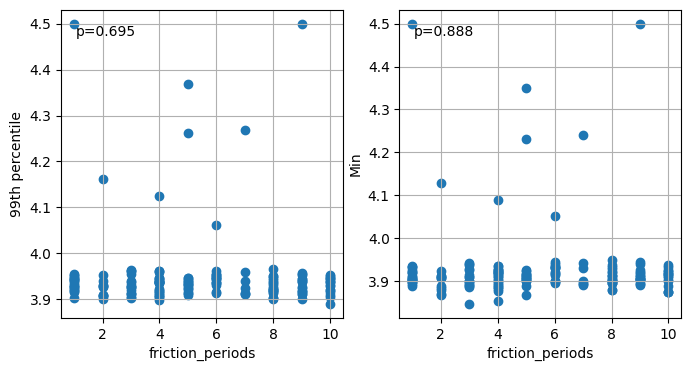

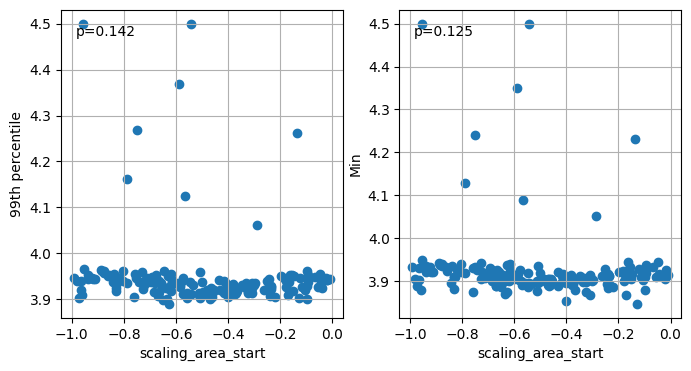

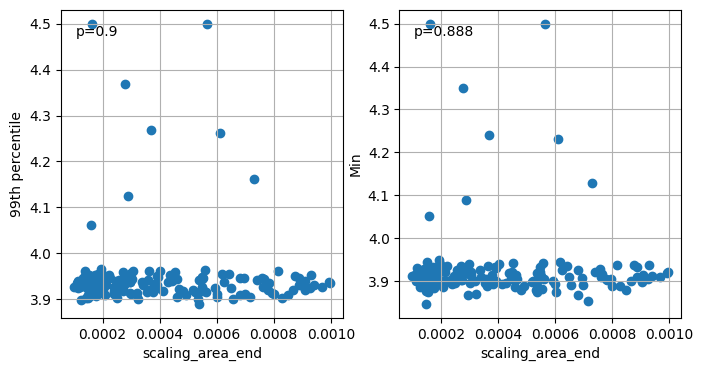

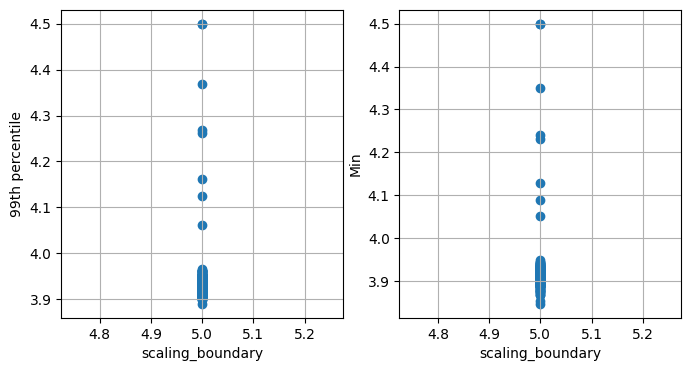

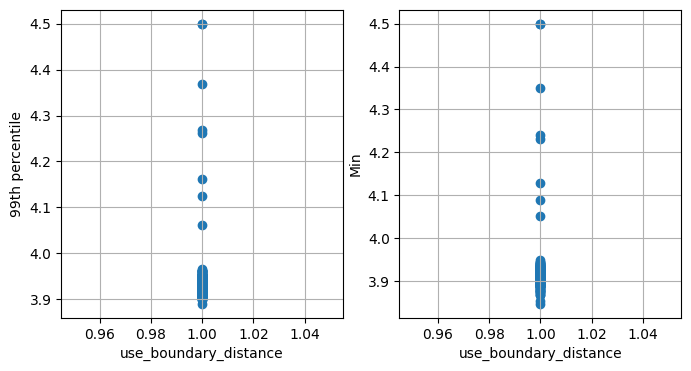

In [11]:
runners = kgs.dill_load(kgs.temp_dir + '/runner_dt_mom_vary6.pickle2')

def plot_two(p99,min_val,xv,xl, plot_mode='line'):
    """Plot two panels: left = 99th percentile, right = min."""
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    # Left panel: 99th percentile
    plt.sca(ax[0])
    if plot_mode == 'line':
        ax[0].plot(xv, p99)
    else:
        ax[0].scatter(xv, p99)
        # compute linear fit and show p-value for slope
        try:
            lr = stats.linregress(xv, p99)
            pval = lr.pvalue
            ax[0].text(0.05, 0.95, f'p={pval:.3g}', transform=ax[0].transAxes, va='top')
        except Exception:
            pass
    plt.grid(True)
    plt.xlabel(xl)
    plt.ylabel('99th percentile')
    # Right panel: min
    plt.sca(ax[1])
    if plot_mode == 'line':
        ax[1].plot(xv, min_val)
    else:
        ax[1].scatter(xv, min_val)
        try:
            lr2 = stats.linregress(xv, min_val)
            pval2 = lr2.pvalue
            ax[1].text(0.05, 0.95, f'p={pval2:.3g}', transform=ax[1].transAxes, va='top')
        except Exception:
            pass
    plt.grid(True)
    plt.xlabel(xl)
    plt.ylabel('Min')

runners = [r for r in runners if (r['scaling_area_start']<10**0.2 and r['duration_compact']>25)]

sizes = np.array([r['sizes'] for r in runners])
sizes[np.isnan(sizes)] = np.inf
sizes[sizes>4.5] = 4.5
p99 = np.percentile(sizes, 1, axis=1)
min_val = np.min(sizes, axis=1)
plot_two(p99.T, min_val.T, np.arange(p99.shape[1])+1, 'Round')

# plt.figure(figsize=(20,20))
# plt.plot(sizes.reshape(-1,sizes.shape[2]).T, linewidth=0.5)

p99 = np.percentile(np.min(sizes,axis=2), 1, axis=1)
min_val = np.min(sizes, axis=(1,2))
plot_two(p99, min_val, [r['size_setup'] for r in runners], 'size_setup', plot_mode='scatter')
plot_two(p99, min_val, [r['duration_init'] for r in runners], 'duration_init', plot_mode='scatter')
plot_two(p99, min_val, [r['duration_compact'] for r in runners], 'duration_compact', plot_mode='scatter')
#plot_two(p99, min_val, [r['duration_final'] for r in runners], 'duration_final', plot_mode='scatter')
plot_two(p99, min_val, [r['dt'] for r in runners], 'dt', plot_mode='scatter')
plot_two(p99, min_val, [r['friction_min'] for r in runners], 'friction_min', plot_mode='scatter')
plot_two(p99, min_val, [r['friction_periods'] for r in runners], 'friction_periods', plot_mode='scatter')
plot_two(p99, min_val, np.log([r['scaling_area_start'] for r in runners])/np.log(10), 'scaling_area_start', plot_mode='scatter')
plot_two(p99, min_val, [r['scaling_area_end'] for r in runners], 'scaling_area_end', plot_mode='scatter')
plot_two(p99, min_val, [r['scaling_boundary'] for r in runners], 'scaling_boundary', plot_mode='scatter')
#plot_two(p99, min_val, [r['scaling_overlap'] for r in runners], 'scaling_overlap', plot_mode='scatter')
plot_two(p99, min_val, [r['use_boundary_distance'] for r in runners], 'use_boundary_distance', plot_mode='scatter')

In [6]:
runners[0]

{'comment': '',
 '_is_frozen': True,
 'n_trees': 40,
 'n_ensembles': 1000,
 'n_rounds': 10,
 'plot_interval': None,
 'seed': 0,
 'size_setup': 0.65,
 'duration_init': 4.546720449343393,
 'duration_compact': 101.85991851582833,
 'dt': 0.033920963719982024,
 'scaling_area_start': 0.4745201628239638,
 'scaling_area_end': 0.0002460988309132511,
 'scaling_boundary': 5.0,
 'scaling_overall_factor': 10.0,
 'use_boundary_distance': True,
 'friction_min': 0.39953253507974607,
 'friction_max': 0.0,
 'friction_periods': 6,
 'sizes': array([[4.0244613, 4.008639 , 3.9981751, ..., 4.039684 , 4.1891894,
         4.0204983],
        [4.059621 , 4.0030427, 4.0487547, ..., 3.9960713, 4.1570745,
         4.020385 ],
        [4.0335994, 4.01457  , 4.0794725, ..., 4.201202 , 3.993447 ,
         4.025266 ],
        ...,
        [4.0588655, 4.131299 , 4.092452 , ..., 4.0259447, 4.034381 ,
         4.0253644],
        [4.031137 , 4.034168 , 4.038573 , ..., 4.081336 , 4.0298777,
         4.0103188],
        [4

In [12]:
3.82**2/40*200

72.96199999999999

In [13]:
8.3**2/197*200

69.93908629441627